In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 1. Đọc dữ liệu và parse cột date
train = pd.read_csv("../Dataset/712/train.csv", parse_dates=["date"])
valid = pd.read_csv("../Dataset/712/validation.csv", parse_dates=["date"])
test = pd.read_csv("../Dataset/712/test.csv", parse_dates=["date"])

In [ ]:
# 2. Gộp toàn bộ dữ liệu để phân tích
df_all = pd.concat([train, valid, test], ignore_index=True)

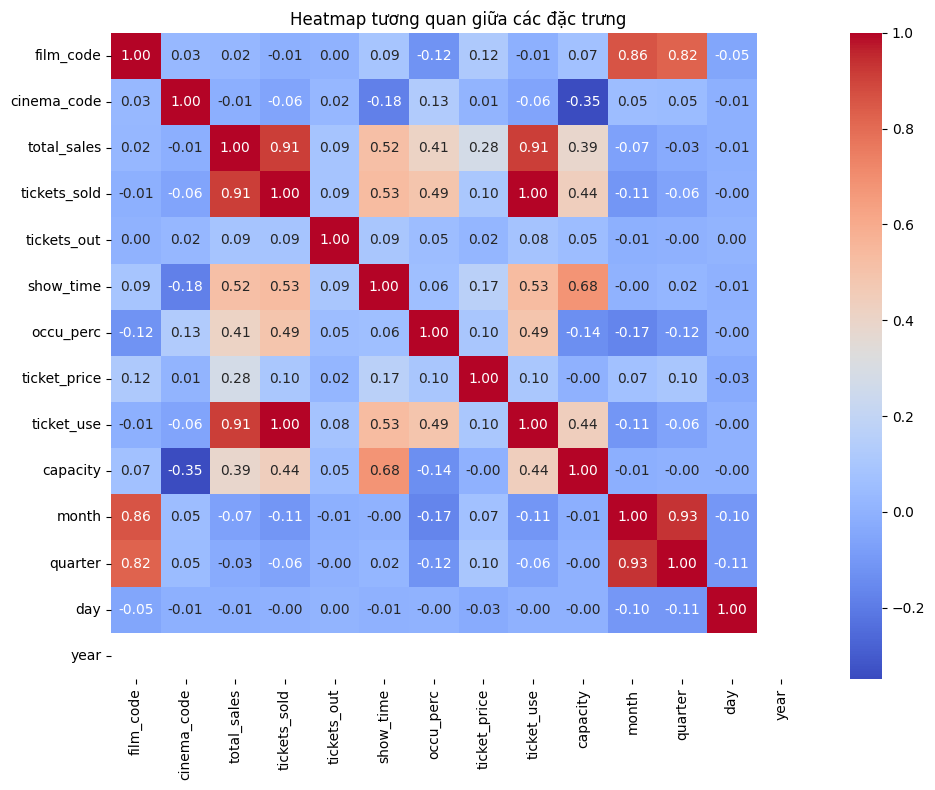

In [ ]:
# 3. Vẽ heatmap tương quan
corr_matrix = df_all.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các đặc trưng")
plt.tight_layout()
plt.show()

In [ ]:
# 4. Chọn các đặc trưng có tương quan cao với total_sales
target_corr = corr_matrix['total_sales'].drop('total_sales')
relevant_features = target_corr[abs(target_corr) >= 0.3].sort_values(ascending=False)
selected_features = relevant_features.index.tolist()

In [ ]:
# 5. Chuẩn hóa dữ liệu và tạo chuỗi thời gian
sequence_length = 30
features = selected_features
target = 'total_sales'

train_valid = pd.concat([train, valid], ignore_index=True)
df_model = pd.concat([train_valid, test], ignore_index=True)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[[target]])

In [ ]:
# 6. Chỉ tạo sequence trên toàn bộ dữ liệu (để forecast tiếp từ cuối test)
def create_sequences(x, y, seq_len):
    xs, ys = [], []
    for i in range(seq_len, len(x)):
        xs.append(x[i-seq_len:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled, sequence_length)

In [ ]:
# 7. Dùng train + valid để train mô hình (loại bỏ phần test)
train_valid_len = len(train_valid)
X_train = X_all[:train_valid_len - sequence_length]
y_train = y_all[:train_valid_len - sequence_length]

In [ ]:
# 8. Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 9. Huấn luyện mô hình
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.3688e-04
Epoch 2/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 6.8758e-04
Epoch 3/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.4791e-04
Epoch 4/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 6.0549e-04
Epoch 5/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 5.9545e-04
Epoch 6/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 5.9336e-04
Epoch 7/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 5.9784e-04
Epoch 8/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 7.0475e-04
Epoch 9/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.8013e-04
Epoch 10/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.0328e-04
Epoch 11/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.6128e-04
Epoch 12/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.6506e-04
Epoch 13/20
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.9827e-04
Epoch 14/20
2686/2686 ━━━━━━━━━━━━

In [ ]:
# Đánh giá
# Dự đoán trên tập test để đánh giá
X_test_eval = X_all[train_valid_len - sequence_length : len(df_model) - sequence_length]
y_test_eval = y_all[train_valid_len - sequence_length : len(df_model) - sequence_length]

y_pred_scaled = model.predict(X_test_eval, verbose = 0)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_eval)

# Tính các độ đo đánh giá
mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100

# In kết quả
print("Evaluation Metrics on Test Set:")
print(f"MAE  = {mae:.2f}")
print(f"MSE  = {mse:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

Evaluation Metrics on Test Set:
MAE  = 9787410.96
MSE  = 760326990997340.75
RMSE = 27574027.47
MAPE = 463.84%


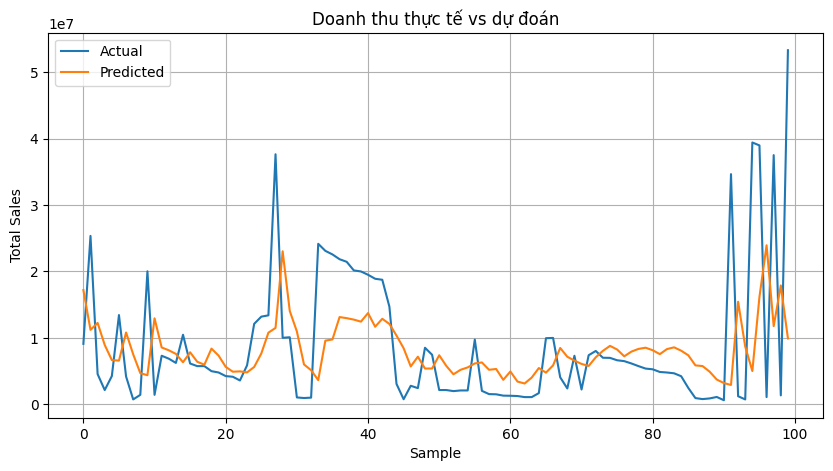

In [73]:
# 6. Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_real[:100], label='Actual')
plt.plot(y_pred_real[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [ ]:
# 10. Dự đoán 30 ngày tiếp theo từ điểm cuối của test
last_sequence_input = X_scaled[-sequence_length:].reshape(1, sequence_length, len(features))
future_preds = []

for _ in range(30):
    next_pred = model.predict(last_sequence_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_sequence_input = np.append(last_sequence_input[:,1:,:], [[X_scaled[-1]]], axis=1)

future_preds_real = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))
last_date = df_model['date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

In [72]:
# Tạo DataFrame chứa dự đoán
future_preds_real_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_preds_real.flatten(),
    'type': 'Forecasted Sales'})
print(future_preds_real_df)

         date  total_sales              type
0  2018-12-11   23030864.0  Forecasted Sales
1  2018-12-12   30316064.0  Forecasted Sales
2  2018-12-13   32999218.0  Forecasted Sales
3  2018-12-14   34026388.0  Forecasted Sales
4  2018-12-15   34502824.0  Forecasted Sales
5  2018-12-16   34797540.0  Forecasted Sales
6  2018-12-17   34935800.0  Forecasted Sales
7  2018-12-18   34948364.0  Forecasted Sales
8  2018-12-19   34898888.0  Forecasted Sales
9  2018-12-20   34757944.0  Forecasted Sales
10 2018-12-21   34646952.0  Forecasted Sales
11 2018-12-22   34483300.0  Forecasted Sales
12 2018-12-23   34523380.0  Forecasted Sales
13 2018-12-24   34330784.0  Forecasted Sales
14 2018-12-25   34192892.0  Forecasted Sales
15 2018-12-26   34027784.0  Forecasted Sales
16 2018-12-27   33844808.0  Forecasted Sales
17 2018-12-28   33680124.0  Forecasted Sales
18 2018-12-29   33525882.0  Forecasted Sales
19 2018-12-30   33385266.0  Forecasted Sales
20 2018-12-31   33259100.0  Forecasted Sales
21 2019-01

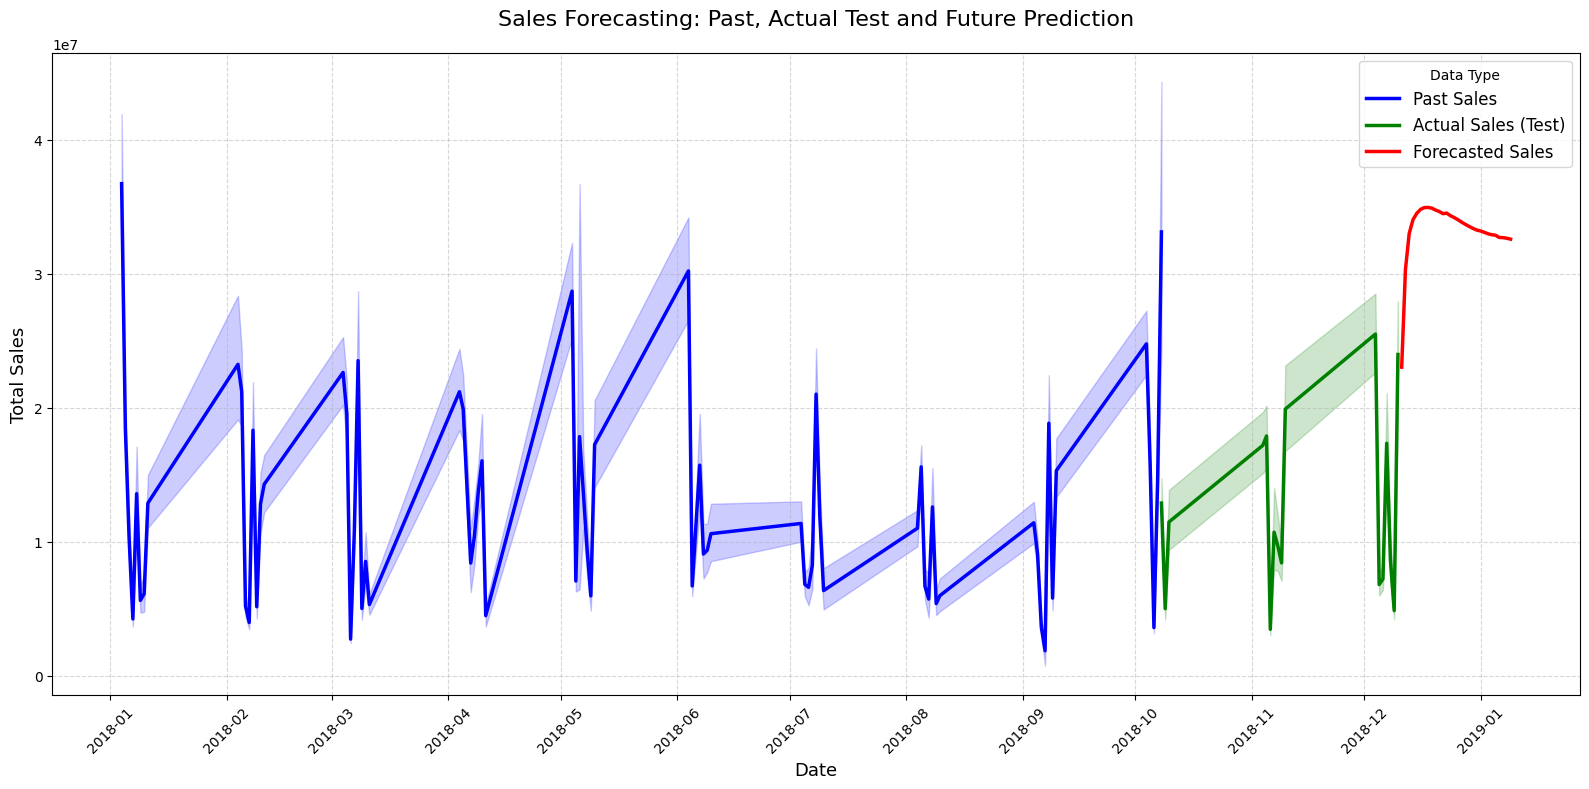

In [70]:
# 11. Vẽ biểu đồ
# Chuẩn bị dữ liệu quá khứ để visualization
train['type'] = 'Past Sales'
valid['type'] = 'Past Sales'
test['type'] = 'Actual Sales (Test)'  # Thêm thông tin cho test data

# Gộp tất cả dữ liệu
combined_df = pd.concat([
    train[['date', 'total_sales', 'type']],
    valid[['date', 'total_sales', 'type']],
    test[['date', 'total_sales', 'type']],
    future_preds_real_df
], ignore_index=True)

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Thêm các chi tiết cho đồ thị
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()